# HW3 for CSCI 699 

by Thamme Gowda

In [1]:
import numpy as np
from IPython.display import display
from PIL import Image
from time import time
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm import tqdm
import logging as log
log.basicConfig(level=log.INFO)

In [2]:
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_properties(i), torch.cuda.get_device_capability(i))

0 _CudaDeviceProperties(name='GeForce GTX TITAN X', major=5, minor=2, total_memory=12204MB, multi_processor_count=24) (5, 2)
1 _CudaDeviceProperties(name='Tesla K40m', major=3, minor=5, total_memory=11439MB, multi_processor_count=15) (3, 5)


In [4]:
!ls data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz

data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz


In [3]:
dsprites_file = 'data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
ids_file = 'data/ids.npz'

data = np.load(dsprites_file)
print(data.files)
ids = np.load(ids_file)
print(ids.files)

all_imgs = data['imgs']

# for task 1: B-VAE
train_imgs = all_imgs[ids['train']]

# for q1_a.pdf 
test_reconstruct = all_imgs[ids['test_reconstruct']]
# for q1_b.pdf 
test_interpolate = all_imgs[ids['test_interpolate']]

# for task 2: supervision of latent space
sup_train_imgs = all_imgs[ids['supervised_train']]
sup_train_factors = data['latents_values'][ids['supervised_train']]
sup_train_classes = data['latents_classes'][ids['supervised_train']]

train_imgs.shape, test_reconstruct.shape, test_interpolate.shape

['metadata', 'imgs', 'latents_classes', 'latents_values']
['supervised_train', 'train', 'test_reconstruct', 'test_interpolate']


((245760, 64, 64), (15, 64, 64), (5, 2, 64, 64))

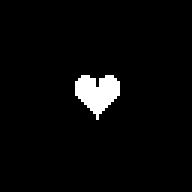

In [4]:
def display_image(data, scale=1, factor=255):
    data = data.numpy() if hasattr(data, 'numpy') else data
    data = data * factor
    if data.dtype != 'uint8':
        data = data.astype('uint8')
    img = Image.fromarray(data)
    if scale != 1:
        img = img.resize((img.width * scale, img.height*scale), Image.NEAREST)
    display(img)

display_image(test_interpolate[1][1], scale=3)

In [5]:
np.random.seed(12345)
if train_imgs.data.ndim < 4:
    train_imgs = np.expand_dims(train_imgs, axis=1)  # add a dummy dim for single channel
if train_imgs.dtype != 'float32':
    train_imgs = train_imgs.astype('float32', copy=False)
np.random.shuffle(train_imgs)
validn_count = 10_000
validn_imgs, train_split_imgs = train_imgs[:validn_count], train_imgs[validn_count:]
log.info(f'{validn_imgs.shape} {train_split_imgs.shape}')

INFO:root:(10000, 1, 64, 64) (235760, 1, 64, 64)


In [6]:
class LoopingIterator:
    
    def __init__(self, iterable, total_steps):
        self.total_steps = total_steps
        self.iterable = iterable

    def __len__(self):
        return self.total_steps

    def __iter__(self):
        count = 0
        while count < self.total_steps:
            for item in self.iterable:
                yield item
                count += 1 
                if count >= self.total_steps:
                    break


## Beta VAE

https://github.com/1Konny/Beta-VAE/blob/master/model.py

In [7]:
# Some or most of the model Code taken from https://github.com/1Konny/Beta-VAE/blob/master/model.py

class View(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

class BetaVAE(nn.Module):
    
    def __init__(self, z_dim, inp_chs=1, enc_dim=None, use_norm=False):
        super().__init__()
        self.z_dim = z_dim
        self.enc_dim = enc_dim or 2 * z_dim
        self.use_norm = use_norm        
        enc_layers = [
            nn.Conv2d(inp_chs, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  8,  8
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  4,  4
            nn.ReLU(True),
            View((-1, 32*4*4)),                  # B, 512
            nn.Linear(32*4*4, 256),              # B, 256
            nn.ReLU(True),
            nn.Linear(256, 256),                 # B, 256
            nn.ReLU(True),
            nn.Linear(256, self.enc_dim),             # B, z_dim*2            
        ]
        
        if self.use_norm:
            enc_layers = [nn.LayerNorm((inp_chs, 64, 64))] + enc_layers + [nn.LayerNorm(self.enc_dim)]
        self.encoder = nn.Sequential(*enc_layers)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            nn.ReLU(True),
            nn.Linear(256, 256),                 # B, 256
            nn.ReLU(True),
            nn.Linear(256, 32*4*4),              # B, 512
            nn.ReLU(True),
            View((-1, 32, 4, 4)),                # B,  32,  4,  4
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, inp_chs, 4, 2, 1), # B,  nc, 64, 64
        )
    
    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                self.kaiming_init(m)
                
    def kaiming_init(self, m):
        # TODO: Read this https://arxiv.org/pdf/1502.01852.pdf 
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            init.kaiming_normal(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0)
        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
            m.weight.data.fill_(1)
            if m.bias is not None:
                m.bias.data.fill_(0)

    def forward(self, x):
        """
        returns x_reconstruction_logits, mus, logvars
        """
        orig_shape = x.shape
        z, mu, logvar = self.encode(x)
        x_recon_logits = self.decode(z)

        #x_recon = F.sigmoid(x_recon) # squash to [0, 1]
        assert orig_shape == x_recon_logits.shape
        return x_recon_logits, mu, logvar
    
    def encode(self, x):
        distributions = self.encoder(x)
        mu = distributions[:, :self.z_dim]
        #mu = F.softmax(mu)
        logvar = distributions[:, self.z_dim:]

        # Note: this doesnt match what Prof. Greg taught in class
        # see slides 36-42: https://drive.google.com/file/d/1gMv5JOsEH7cpL_I_GBdloGoeMEp1anj2/view
        # here, we are assuming the encoder directly provides log(s_x)^2 instead of s_x

        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z, squash=False):
        logits = self.decoder(z)
        return torch.sigmoid(logits) if squash else logits 
    
    def reparametrize(self, mu, logvar):
        std = logvar.div(2).exp()
        #eps = Variable(std.data.new(std.size()).normal_())
        eps = torch.zeros(std.shape, device=std.device).normal_()
        #with torch.no_grad():
        #    eps = self.noise_dist.sample((mu.shape[0],))
        #print(mu.device, std.device, eps.device, '::', mu.shape, std.shape, eps.shape)
        return mu + std * eps


PosixPath('/media/storage_f/tg/phd/cs699-f19/hw3.ipynb')

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log.info(f"DEVICE={DEVICE}")
NOTEBOOK = Path('/media/storage_f/tg/phd/cs699-f19/hw3.ipynb') # take a backup in dir

class BetaVAETrainer:
    
    def __init__(self, vae_model, beta, run_dir, device=DEVICE, nosave=False, lr=5e-4,
                 adam_betas=(0.5, 0.999), adam_weight_decay=0):
        self.device = DEVICE
        self.model = vae_model.to(device)
        self.beta = beta
        self.optim = torch.optim.Adam(params=self.model.parameters(), lr=lr,
                                      betas=adam_betas, weight_decay=adam_weight_decay)
        self.run_dir = run_dir
        self.tbd = SummaryWriter(log_dir=run_dir, flush_secs=60, max_queue=50)
        self.cur_step = 0
        self.models_dir = Path(self.run_dir) / 'models'
        self.nosave = nosave
        if not self.models_dir.exists():
            self.models_dir.mkdir(parents=True)
        # backup of code 
        (Path(run_dir) / 'code.ipynb').write_bytes(NOTEBOOK.read_bytes())

    def validate(self, data) -> float:
        self.model.eval()
        val_losses = []
        with torch.no_grad():
            for i, batch in enumerate(data):
                batch = batch.to(self.device)
                recon_batch, mu, logvar = self.model(batch)
                recon_loss = self.reconstruction_loss(batch, recon_batch)
                val_losses.append(recon_loss.item())
                if i == 0: # first batch
                    # log some images to viz progress
                    batch_rec = torch.sigmoid(recon_batch).cpu()
                    self.tbd.add_images('reconstruction', batch_rec, self.cur_step)
        return sum(val_losses) / len(val_losses)

    def checkpoint(self, val_loss, train_loss):
        """Saves model parameters to disk."""
        if self.nosave:
            return
        model_out_file = f'model_{self.cur_step}_val{val_loss:.2f}_train{train_loss:.2f}.pth'
                                   
        model_out_file = self.models_dir / model_out_file
        log.info(f'Saving model state to {model_out_file}')
        # model = self.model.to('cpu')
        chkpt = {'model_state': self.model.state_dict(), 
                'optim': self.optim.state_dict(),
                'step': self.cur_step}
        torch.save(chkpt, model_out_file)
        
    def train(self, steps, train_data, validn_data, chkpt):
        train_data = LoopingIterator(train_data, total_steps=steps - self.cur_step)
        if self.cur_step <= 1:
            # log some images to viz progress
            for first_batch in validn_data:
                break
            self.tbd.add_images('originals', first_batch, self.cur_step)

        self.model.train()
        start = time()
        n_imgs = 0
        train_recons = []
        with tqdm(train_data, initial=self.cur_step, total=steps) as data_bar:
            for batch in data_bar:
                self.cur_step += 1
                if self.cur_step % chkpt == 0:
                    # validation
                    val_loss = self.validate(validn_data)
                    train_loss = sum(train_recons) / len(train_recons)
                    self.tbd.add_scalars('ReconsLoss', {
                        'train': train_loss,
                        'validn': val_loss
                    }, self.cur_step)
                    self.checkpoint(val_loss, train_loss)

                    self.model.train()
                    start = time()
                    n_imgs = 0
                    train_recons.clear()

                self.optim.zero_grad() # clear accumulated grads for all params
                batch = batch.to(self.device)
                
                recon_batch, mu, logvar = self.model(batch)
                recon_loss = self.reconstruction_loss(batch, recon_batch)
                diverg_loss = self.latent_diverg_loss(mu, logvar)
                combo_loss = recon_loss + self.beta * diverg_loss
                #combo_loss = recon_loss
                if self.cur_step % 20 == 0:
                    self.tbd.add_scalars('train_losses', {
                        'combo': combo_loss.item(),
                        'reconst': recon_loss.item(),
                        'diverg': diverg_loss.item()
                    }, self.cur_step)
                train_recons.append(recon_loss.item())
                combo_loss.backward()
                self.optim.step()

                n_imgs += batch.shape[0]
                data_bar.set_postfix(loss=combo_loss.item(), recon_loss=recon_loss.item(), kld=diverg_loss.item(),
                                speed=f'{n_imgs/(time()-start):.1f} img/sec')

    
    def reconstruction_loss(self, original, recon_logits):
        batch_size = original.shape[0]
        assert original.shape == recon_logits.shape

        losses = F.binary_cross_entropy_with_logits(recon_logits, original, reduction='none')
        # Sum all pixel losses per each image, then mean over batch
        loss = losses.view(batch_size, -1).mean(dim=1).mean(dim=0)
        #loss = F.binary_cross_entropy_with_logits(recon_logits, original, size_average=False).div(batch_size)
        return loss
    
    def latent_diverg_loss(self, mu, logvar):
        # Note: this doesnt match what Prof. Greg taught in class
        # see slides 36-42: https://drive.google.com/file/d/1gMv5JOsEH7cpL_I_GBdloGoeMEp1anj2/view
        batch_size = mu.shape[0]
        assert batch_size > 0
        assert mu.shape[1] == logvar.shape[1] == self.model.z_dim
        
        klds = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        total_kld = klds.sum(1).mean(0, True)
        
        # this is as in slides
        #klds = -0.5 * (1 + logvar.pow(2).log() - mu.pow(2) - logvar.pow(2))
    
        #dimension_wise_kld = klds.mean(0)
        #mean_kld = klds.mean(1).mean(0, True)
        #return total_kld, dimension_wise_kld, mean_kld
        return total_kld


INFO:root:DEVICE=cuda


In [11]:
vae_model = BetaVAE(z_dim=25, inp_chs=1)
trainer = BetaVAETrainer(vae_model=vae_model, beta=5, run_dir='runs/runs-008-z25-b5')

In [ ]:
batch_size = 200
val_data = DataLoader(validn_imgs, shuffle=False, batch_size=batch_size)
train_data = DataLoader(train_split_imgs, shuffle=True, batch_size=batch_size)
trainer.train(steps=50000, train_data = train_data, validn_data=val_data, chkpt=1000)

In [ ]:
start_step = 100_000
trainer.cur_step = start_step
trainer.beta = 2 # reduce beta
trainer.train(steps=start_step+50_000, train_data = train_data, validn_data=val_data, chkpt=1000)

In [10]:
import tensorboard
from tensorboard import notebook as tbdnb
print(tensorboard.version.VERSION)
tbdnb.list()

1.14.0
No known TensorBoard instances running.


In [ ]:
tbdnb.display(port=6006, height=768) 

# Restore model

In [3]:
!ls runs-006-z50-b0.1/models/model_100000_val10.43_train10.30.pth

runs-006-z50-b0.1/models/model_100000_val10.43_train10.30.pth


In [14]:
model = BetaVAE(z_dim=25, inp_chs=1, use_norm=False)
chkpt_path = 'runs/runs-008-z25-b5/models/model_150000_val24.82_train24.23.pth'

#model = BetaVAE(z_dim=25, inp_chs=1)
#chkpt_path = 'runs-008-z25-b0.5/models/model_50000_val22.82_train23.44.pth'


#model = BetaVAE(z_dim=20, inp_chs=1)
#chkpt_path = 'runs-007-z20-b1/models/model_50000_val30.83_train29.75.pth'
#chkpt_path = 'runs-007-z20-b1/models/model_100000_val22.45_train22.08.pth'

chkpt = torch.load(chkpt_path, map_location=DEVICE)
model.load_state_dict(chkpt['model_state'])
model = model.to(DEVICE)
model = model.eval()
model

BetaVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace)
    (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace)
    (8): View()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU(inplace)
    (11): Linear(in_features=256, out_features=256, bias=True)
    (12): ReLU(inplace)
    (13): Linear(in_features=256, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU(inplace)
    (6): View()
    (7): ConvTranspose2d(

# Reconstruction


In [107]:
recon_imgs = model(torch.tensor(test_reconstruct, dtype=torch.float).view(-1, 1, 64,64).cuda())[0]
recon_imgs = torch.sigmoid(recon_imgs).detach().cpu()

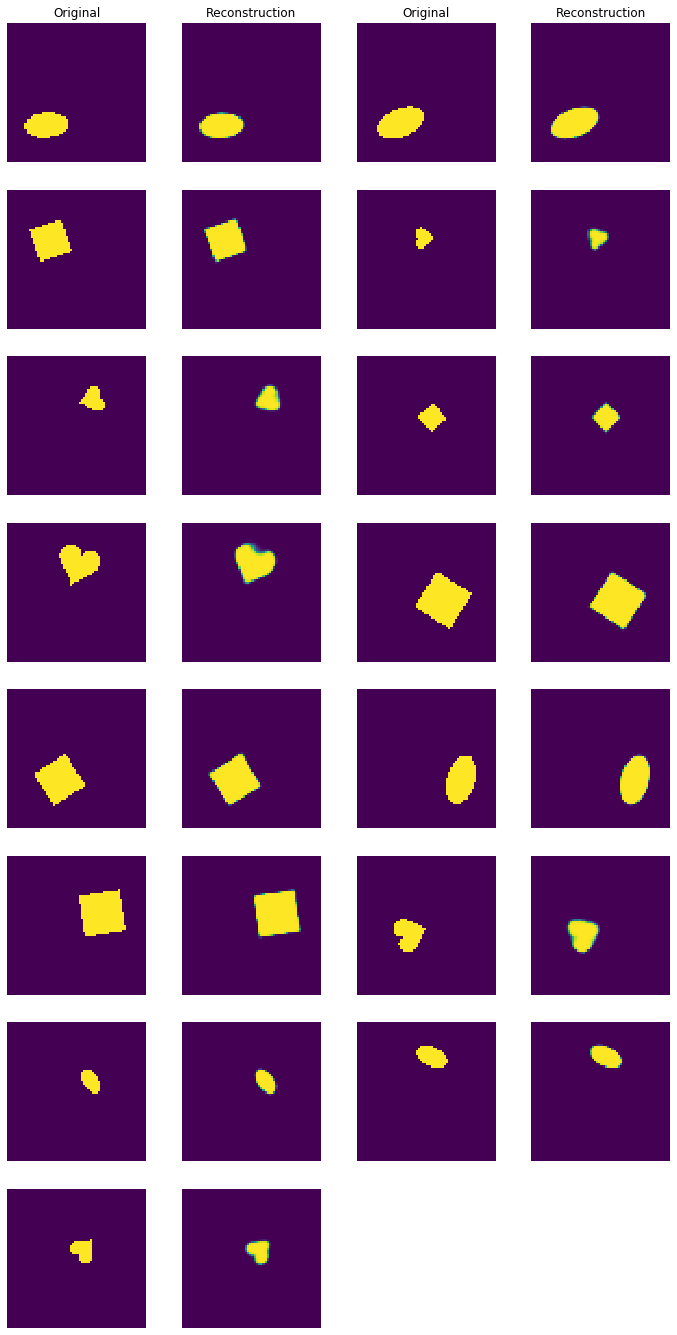

In [116]:

fig = plt.figure(figsize=(12, 24))

columns = 4
rows = 8
assert len(test_reconstruct) <= columns * rows * 0.5

for i in range(len(test_reconstruct)):
    #img = np.random.randint(255, size=(h,w))
    
    orig = test_reconstruct[i] * 255
    subp = fig.add_subplot(rows, columns, 2*i + 1)
    if i in (0, 1):
        subp.set_title("Original")
    subp.axis('off')
    plt.imshow(orig)
    
    recon = recon_imgs[i, 0] * 255
    subp = fig.add_subplot(rows, columns, 2*i + 2)
    if i in (0,1):
        subp.set_title("Reconstruction")
    subp.axis('off')        
    plt.imshow(recon)
plt.savefig('q1_a.pdf', bbox_inches='tight')
plt.show()

--- 
# 1b Interpolation


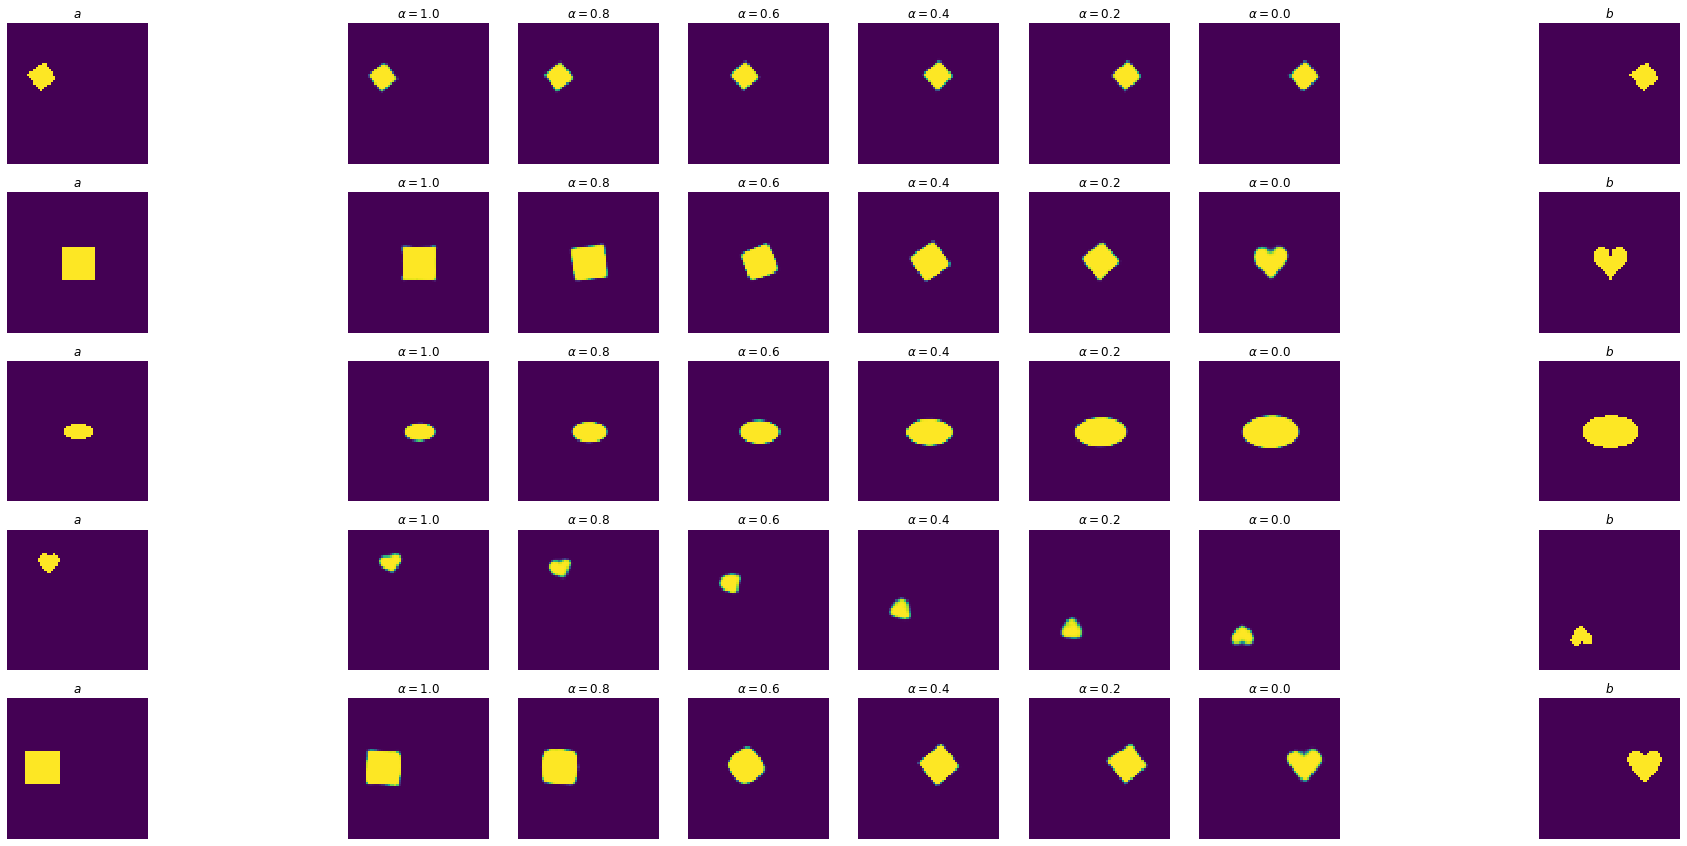

In [15]:
alphas = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]

def plot_interpoloated(imgs, alphas=alphas):
    rows = len(imgs)
    n_mixs = len(imgs[0][2])
    cols = 2 + 2 + n_mixs
    assert n_mixs == len(alphas)

    fig = plt.figure(figsize=(cols*3, rows*3))
    
    for row_idx, (orig_a, orig_b, inters) in enumerate(imgs):
        subp = fig.add_subplot(rows, cols, 1 + row_idx*cols)
        subp.set_title("$a$")
        subp.axis('off')
        plt.imshow(orig_a)

        for idx, (alpha, inter) in enumerate(zip(alphas, inters), start= 3 + row_idx*cols):
            subp = fig.add_subplot(rows, cols, idx)
            subp.set_title(f'$\\alpha={alpha}$')
            subp.axis('off')
            plt.imshow(inter)


        subp = fig.add_subplot(rows, cols, cols + row_idx*cols)
        subp.set_title("$b$")
        subp.axis('off')
        plt.imshow(orig_b)

    plt.savefig('q1_b.pdf')
    plt.show()
    

imgs = []
for pair in test_interpolate:
    a, b = pair[0], pair[1]
    batch_a = torch.tensor([[a]], dtype=torch.float, device=DEVICE)
    batch_b = torch.tensor([[b]], dtype=torch.float, device=DEVICE)
    z_a, _, _ = model.encode(batch_a)
    z_b, _, _ = model.encode(batch_b)
    mix_zs = [alpha * z_a + (1 - alpha) * z_b for alpha in alphas]
    mix_imgs = [model.decode(z, squash=True)[0, 0].detach().cpu() for z in mix_zs]
    imgs.append((a, b, mix_imgs))
    #plot_interpoloated(a, b, inters=mix_imgx, alphas=alphas)

plot_interpoloated(imgs, alphas=alphas)




--- 

# Latent supervision


In [15]:
sup_train_imgs.shape, sup_train_factors.shape, sup_train_classes.shape

((16384, 64, 64), (16384, 6), (16384, 6))

In [11]:
np.random.seed(12345)
if sup_train_imgs.data.ndim < 4:
    sup_train_imgs = np.expand_dims(sup_train_imgs, axis=1)  # add a dummy dim for single channel
if sup_train_imgs.dtype != 'float32':
    sup_train_imgs = sup_train_imgs.astype('float32', copy=False)

# shuffle two arrays the same order
assert len(sup_train_imgs) == len(sup_train_classes)
p = np.random.permutation(len(sup_train_imgs))
sup_train_imgs =  sup_train_imgs[p]
sup_train_classes = sup_train_classes[p]

sup_validn_count = 1_500
sup_validn_imgs, sup_train_split_imgs = sup_train_imgs[:sup_validn_count], sup_train_imgs[sup_validn_count:]
sup_validn_classes, sup_train_split_classes = sup_train_classes[:sup_validn_count], sup_train_classes[sup_validn_count:]
log.info(f'{sup_validn_imgs.shape} {sup_train_split_imgs.shape}:: {sup_validn_classes.shape} {sup_validn_classes.shape}')

INFO:root:(1500, 1, 64, 64) (14884, 1, 64, 64):: (1500, 6) (1500, 6)


In [12]:
factor_dims = [3, 6, 40, 32, 32]
z_partitions = []
for d in factor_dims:
    if z_partitions:
        d += z_partitions[-1]
    z_partitions.append(d)
print(z_partitions)

def quantize_latent(data):
    dims = z_partitions[-1]
    batch_size = len(data)
    dtype = torch.uint8
    quantized = torch.zeros(batch_size, dims, dtype=dtype)
    #ones = torch.ones(batch_size, dtype=dtype)
    start_dim = 0
    for idx, end_dim in enumerate(z_partitions):
        packets = torch.tensor(data[:, idx], device=quantized.device).view(batch_size, 1)
        q_index = start_dim + packets
        quantized.scatter_(dim=1, index=q_index, value=1)
        start_dim = end_dim

    return quantized

sup_train_ys = quantize_latent(sup_train_split_classes[:, 1:])
sup_validn_ys = quantize_latent(sup_validn_classes[:, 1:])

[3, 9, 49, 81, 113]


In [13]:
from torch.utils.data import Dataset, DataLoader

class DSpritesData(Dataset):
    
    def __init__(self, imgs, latents):
        self.imgs = imgs
        self.latents = latents
        assert len(imgs) == len(latents)
        self._len = len(imgs)
    
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        return self.imgs[idx], self.latents[idx]
    
batch_size = 64
sup_train_data = DataLoader(DSpritesData(sup_train_split_imgs, sup_train_ys),
                            batch_size=batch_size, shuffle=True)
sup_validn_data = DataLoader(DSpritesData(sup_validn_imgs, sup_validn_ys),
                            batch_size=batch_size, shuffle=False)
unsup_train_data = DataLoader(train_imgs, shuffle=True, batch_size=batch_size)

In [16]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log.info(f"DEVICE={DEVICE}")


class SSLatentVAE(BetaVAE):

    def __init__(self, z_dim=113, inp_chs=1, z_partitions=z_partitions, dropout=0.1):
        super().__init__(z_dim=z_dim, enc_dim=z_dim, use_norm=True)
        assert z_dim == z_partitions[-1]
        self.z_partitions = z_partitions
        self.z_slices = list(zip([0] + z_partitions, z_partitions))
        
    def forward(self, x):
        z = self.encoder(x)                
        latent = [F.gumbel_softmax(z[:, st: en], hard=True, tau=1) for st, en in self.z_slices]
        latent = torch.cat(latent, dim=1)
        rec_logits = self.decode(latent)
        return rec_logits, z


class LatentTrainer(BetaVAETrainer):

    def __init__(self, lr=5e-4, *args, **kwargs):
        super().__init__(*args, lr=lr, **kwargs)
        self.z_slices = self.model.z_slices

    def sup_loss(self, logits, truth):
        batch_size =  logits.shape[0]
        losses = F.binary_cross_entropy_with_logits(logits, truth, reduction='none')
        # Sum all pixel losses per each image, then mean over batch
        loss = losses.view(batch_size, -1).mean(dim=1).mean(dim=0)
        return loss

    def validate(self, data) -> float:
        self.model.eval()
        val_losses = []
        with torch.no_grad():
            for i, (batch, latent) in enumerate(data):
                batch = batch.to(self.device)
                recon_batch  = self.model(batch)[0]
                recon_loss = self.reconstruction_loss(batch, recon_batch)
                val_losses.append(recon_loss.item())
                if i == 0: # first batch
                    # log some images to viz progress
                    batch_rec = torch.sigmoid(recon_batch).cpu()
                    self.tbd.add_images('reconstruction', batch_rec, self.cur_step)
        return sum(val_losses) / len(val_losses)

    def train(self, steps, sup_train_data, unsup_train_data, validn_data, chkpt, grad_clip=5):
        if grad_clip > 0:
            log.info(f'clipping grad value to {grad_clip}')
        sup_train_data_loop = LoopingIterator(sup_train_data, total_steps=steps - self.cur_step)
        unsup_train_data_loop = LoopingIterator(unsup_train_data, total_steps=steps - self.cur_step)
        if self.cur_step <= 1:
            # log some images to viz progress
            for first_batch, _ in validn_data: break
            self.tbd.add_images('originals', first_batch, self.cur_step)

        self.model.train()
        start = time()
        n_imgs = 0
        train_recons = []
        unsup_data = iter(unsup_train_data_loop)
        zeros_batch = None
        with tqdm(sup_train_data_loop, initial=self.cur_step, total=steps, mininterval=0.5) as data_bar:
            for batch_sup, ys in data_bar:
                self.cur_step += 1
                if self.cur_step % chkpt == 0:
                    # validation
                    val_loss = self.validate(validn_data)
                    train_loss = sum(train_recons) / len(train_recons)
                    self.tbd.add_scalars('ReconsLoss', {
                        'train': train_loss,
                        'validn': val_loss
                    }, self.cur_step)
                    self.checkpoint(val_loss, train_loss)

                    self.model.train()
                    start = time()
                    n_imgs = 0
                    train_recons.clear()

                self.optim.zero_grad() # clear accumulated grads for all params
                batch_sup = batch_sup.to(self.device)
                ys = ys.to(self.device).float()

                recon_batch_sup,  z_logits_sup = self.model(batch_sup)                
                recon_loss_sup = self.reconstruction_loss(batch_sup, recon_batch_sup)
                sup_loss = self.sup_loss(z_logits_sup, ys)

                # Unsupervised data for better reconstruction
                batch_unsup = next(unsup_data).to(self.device)
                recon_batch_unsup, _ = self.model(batch_unsup)
                recon_loss_unsup = self.reconstruction_loss(batch_unsup, recon_batch_unsup)
                
                recon_loss = 0.5 * (recon_loss_sup + recon_loss_unsup)
                combo_loss = recon_loss + self.beta * sup_loss
                if torch.isnan(combo_loss):
                    log.warning(f'Skipping a batch due to NaN loss: C:{combo_loss} RS:{recon_loss_sup} RUS:{recon_loss_unsup} SL:{sup_loss}')
                    continue

                if self.cur_step % 20 == 0:
                    self.tbd.add_scalars('train_losses', {
                        'combo': combo_loss.item(),
                        'recon_sup': recon_loss_sup.item(),
                        'recon_unsup': recon_loss_unsup.item(),                        
                        'sup_loss':  sup_loss.item()                      
                    }, self.cur_step)
                train_recons.append(recon_loss_sup.item())
                combo_loss.backward()
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), grad_clip)
                self.optim.step()

                n_imgs += batch_sup.shape[0] + batch_unsup.shape[0]
                data_bar.set_postfix(comb_loss=combo_loss.item(), recon_loss=recon_loss.item(),
                                     sup_loss=sup_loss.item(),
                                    speed=f'{n_imgs/(time()-start):.1f} img/sec', refresh=False)


INFO:root:DEVICE=cuda


In [ ]:
vae_model = SSLatentVAE(z_dim=113, inp_chs=1)
trainer = LatentTrainer(vae_model=vae_model, beta=0.1, adam_betas=(0.5, 0.999),
                        adam_weight_decay=5e-4, lr=1e-4,
                        run_dir='runs/runs-025-z113-gumbel-norm')

In [ ]:
args = dict(sup_train_data=sup_train_data, unsup_train_data=unsup_train_data,
            validn_data=sup_validn_data, chkpt=1000, grad_clip=0)

trainer.beta = 0.1
trainer.train(steps=100_000, **args)

trainer.beta = 0.4
trainer.train(steps=200_000, **args)

trainer.beta = 0.80
trainer.train(steps=300_000, **args)

trainer.beta = 1
trainer.train(steps=400_000, **args)

In [154]:
!ls -latrh runs/runs-023-z113-gumbel-laynorm-b0.1/models/* | tail -2

-rw-rw-r-- 1 tg tg 6.5M Nov 14 22:25 runs/runs-023-z113-gumbel-laynorm-b0.1/models/model_379000_val0.00_train0.00.pth
-rw-rw-r-- 1 tg tg 6.5M Nov 14 22:25 runs/runs-023-z113-gumbel-laynorm-b0.1/models/model_380000_val0.00_train0.00.pth


---- 
# Q2_B  Interpolation

In [26]:
model = SSLatentVAE(z_dim=113, inp_chs=1)
chkpt_path = 'runs/runs-023-z113-gumbel-laynorm-b0.1/models/model_380000_val0.00_train0.00.pth'

chkpt = torch.load(chkpt_path, map_location=DEVICE)
chkpt['model_state'].pop('z_weight')
chkpt['model_state'].pop('z_bias')

model.load_state_dict(chkpt['model_state'])
model = model.to(DEVICE)
model = model.eval()
model

SSLatentVAE(
  (encoder): Sequential(
    (0): LayerNorm(torch.Size([1, 64, 64]), eps=1e-05, elementwise_affine=True)
    (1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU(inplace)
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU(inplace)
    (9): View()
    (10): Linear(in_features=512, out_features=256, bias=True)
    (11): ReLU(inplace)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU(inplace)
    (14): Linear(in_features=256, out_features=113, bias=True)
    (15): LayerNorm(torch.Size([113]), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=113, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=256

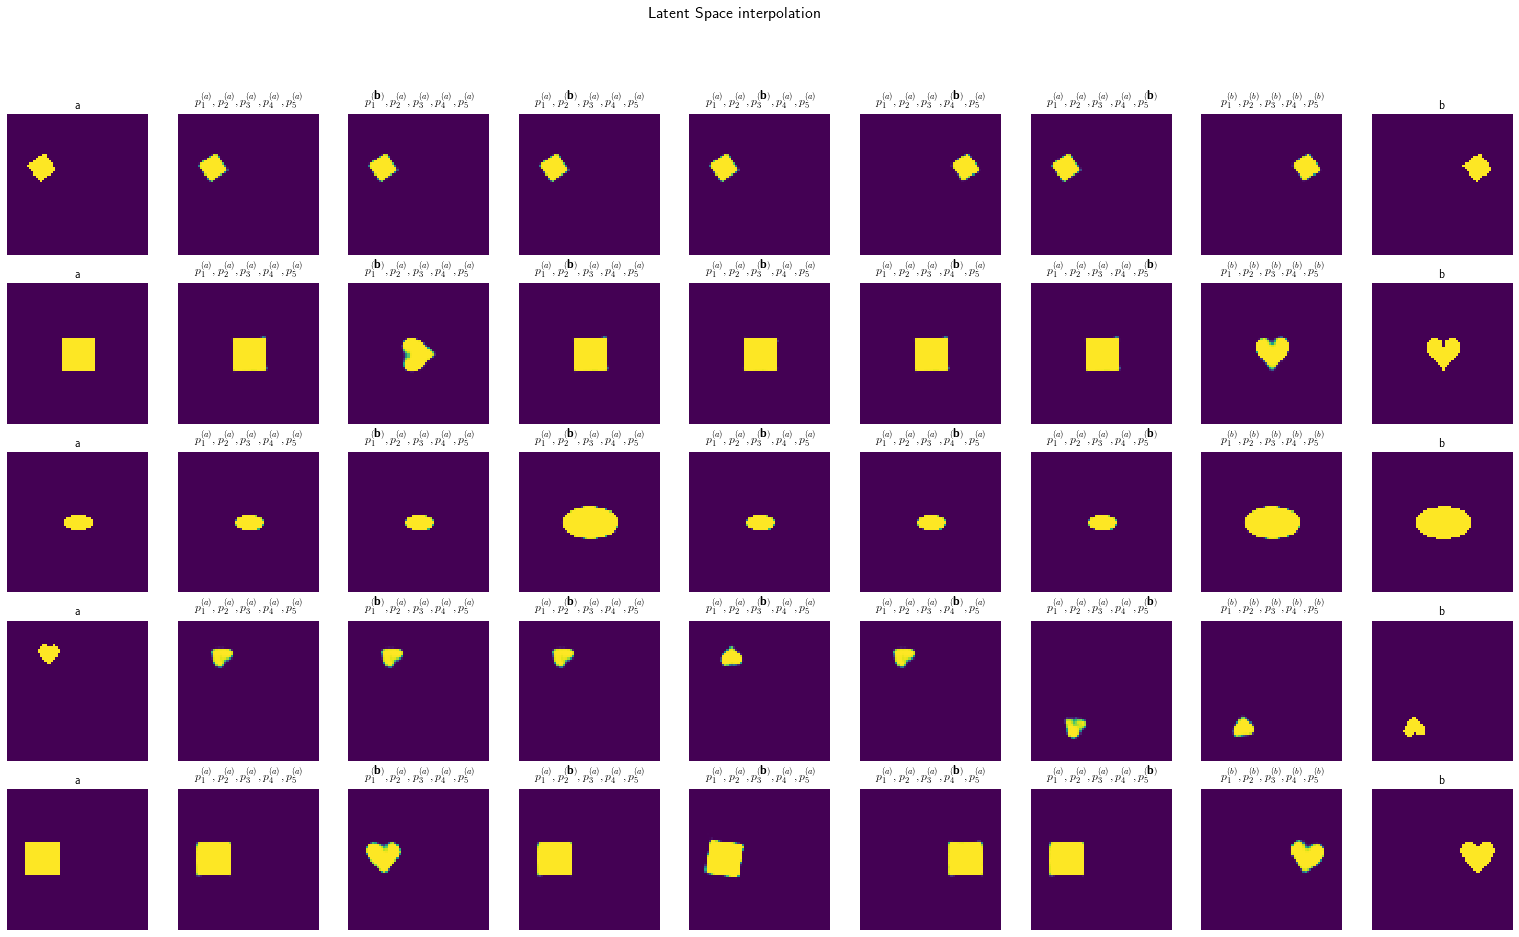

In [40]:
from copy import copy

def plot_img_rows(imgs, titles, cols=6, save=None, fig_title=None):
    rows = len(imgs) // cols
    assert rows * cols == len(imgs)
    assert len(imgs) == len(titles)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    if fig_title:
        fig.suptitle(fig_title, fontsize=16)
    for idx, (img, title) in enumerate(zip(imgs, titles), start=1):
        subp = fig.add_subplot(rows, cols, idx)
        subp.set_title(title)
        subp.axis('off')
        plt.imshow(img)
    if save:
        plt.savefig(save)
    plt.show()

    
model = model.eval()
imgs = []
titles = []


for pair in test_interpolate:
    a, b = pair[0], pair[1]
    
    batch_a = torch.tensor([[a]], dtype=torch.float, device=DEVICE)
    batch_b = torch.tensor([[b]], dtype=torch.float, device=DEVICE)
    z_a  = model.encoder(batch_a)
    z_b  = model.encoder(batch_b)

    z_a_parts = [F.gumbel_softmax(z_a[:, start: end], dim=1, hard=True) for start, end in model.z_slices]
    z_b_parts = [F.gumbel_softmax(z_b[:, start: end], dim=1, hard=True) for start, end in model.z_slices]

    alphas = [-1] + list(range(len(z_b_parts)))
    
    a_recon = model.decode(torch.cat(z_a_parts, dim=1), squash=True)[0, 0].detach().cpu()
    imgs.append(a)
    titles.append('a')
    imgs.append(a_recon)
    titles.append(r"$p_1^{(a)},p_2^{(a)},p_3^{(a)},p_4^{(a)},p_5^{(a)}$")   

    for i, p in enumerate(z_b_parts):
        z = copy(z_a_parts)
        z[i] = p
        img = model.decode(torch.cat(z, dim=1), squash=True)[0, 0].detach().cpu()
        imgs.append(img)
        title = r"$p_1^{(a)},p_2^{(a)},p_3^{(a)},p_4^{(a)},p_5^{(a)}$"
        title = title.replace("p_%d^{(a)}" % (i+1), "p_%d^{(\\textbf{b})} " % (i+1))
        titles.append(title)

    b_recon = model.decode(torch.cat(z_b_parts, dim=1), squash=True)[0, 0].detach().cpu()    
    imgs.append(b_recon)
    titles.append(r"$p_1^{(b)},p_2^{(b)},p_3^{(b)},p_4^{(b)},p_5^{(b)}$")

    imgs.append(b)
    titles.append('b')

plot_img_rows(imgs, titles, cols=9, save='q2_b.pdf', fig_title="Latent Space interpolation")

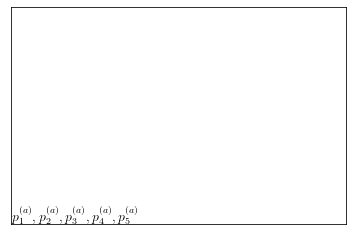

In [24]:

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True


txte = r"$p_1^{(a)},p_2^{(a)},p_3^{(a)},p_4^{(a)},p_5^{(a)}$"


plt.text(0.0, 0.0, txte, fontsize=14)
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.show()

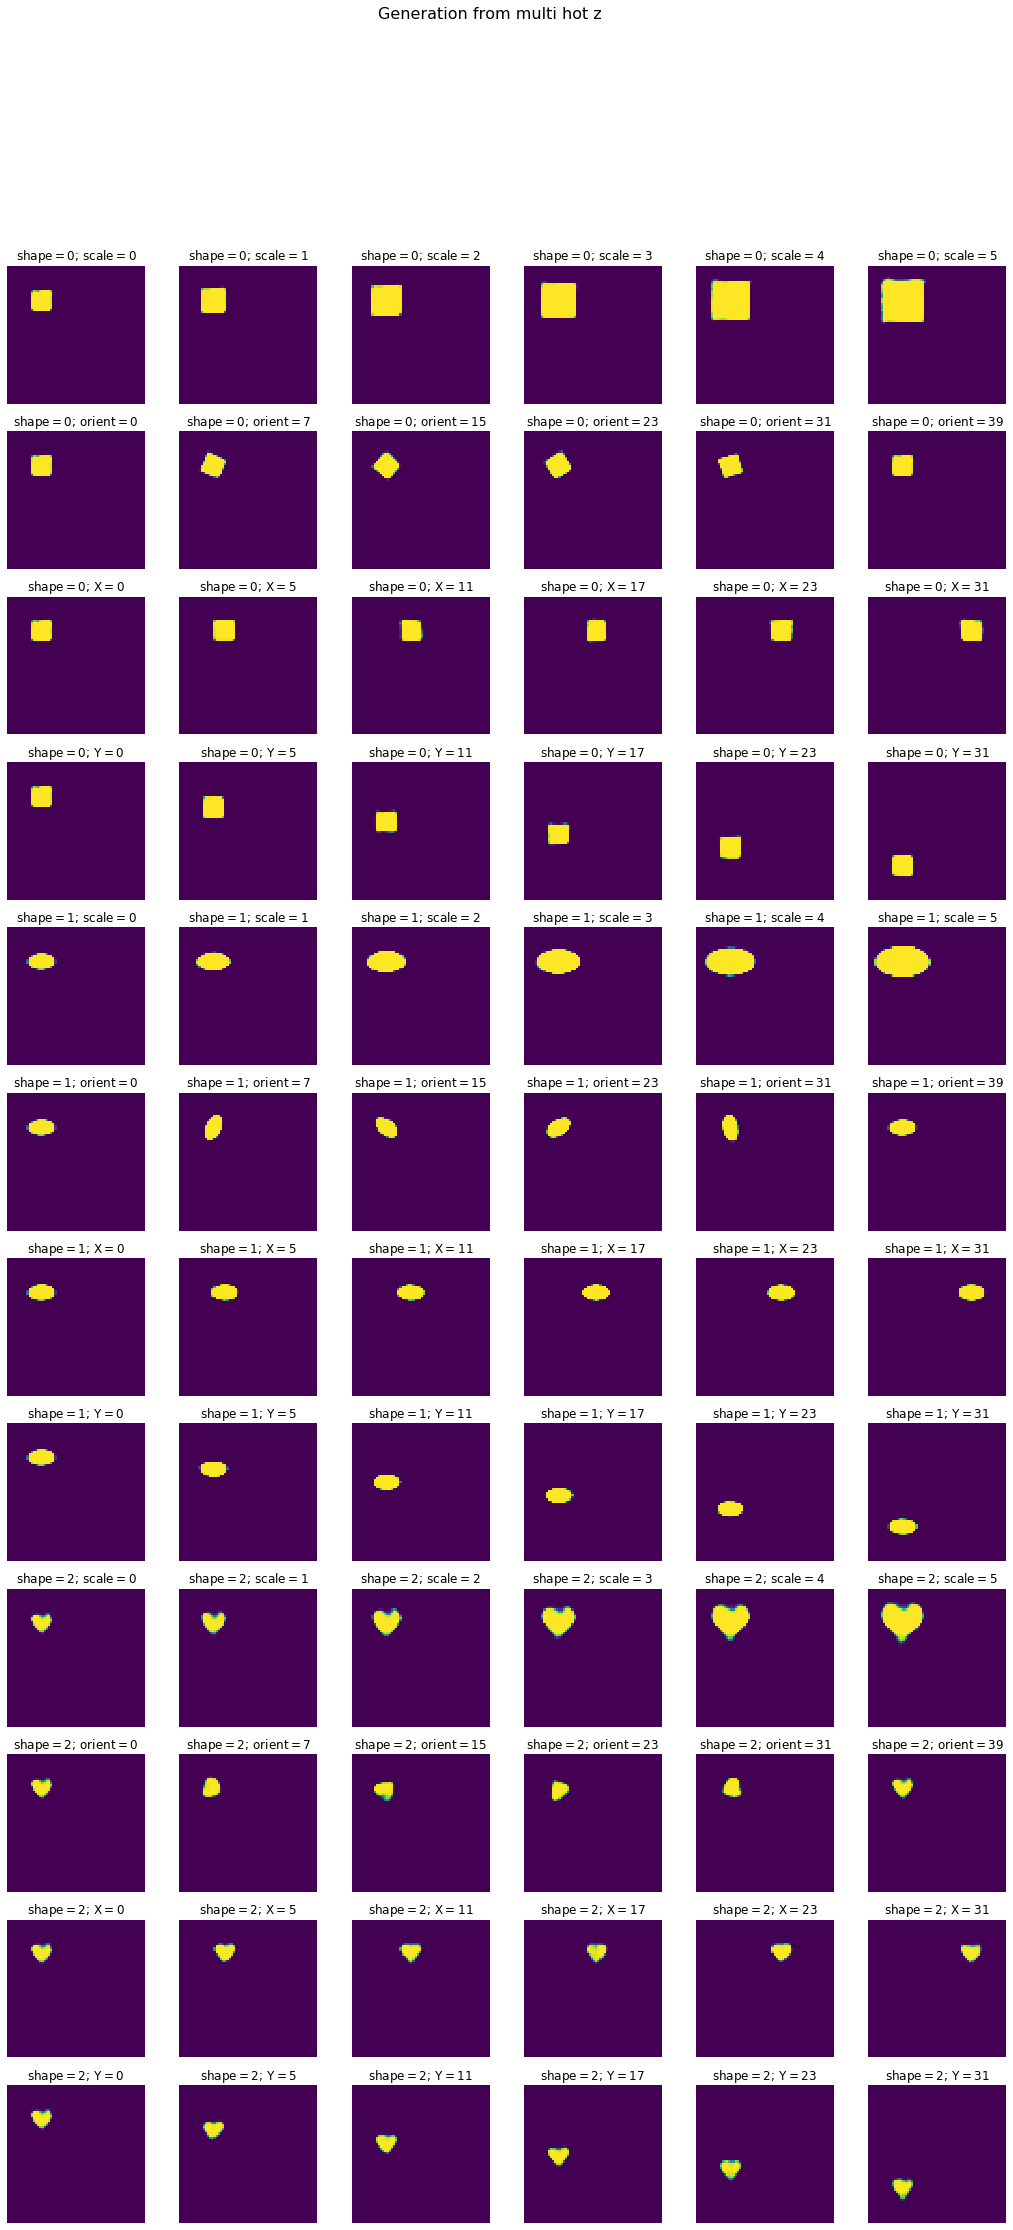

In [153]:

z_dim = 113
samples = [
     ('scale',  3, [0, 1, 2, 3, 4, 5]),     # scale
     ('orient', 9, [0, 7, 15, 23, 31, 39]),   # orient        
     ('X',      49, [0, 5, 11, 17, 23, 31]),  # X Pos
     ('Y',      81, [0, 5, 11, 17, 23, 31])]  # Y Pos
imgs, titles = [], []
for shape in [0, 1, 2]:
    for name, start, poss in samples:
        for pos in poss:
            hots = torch.tensor(list({shape, 3, 9, 49, 81} - {start}) + [start+pos])       
            z = torch.zeros(1, z_dim, device=DEVICE)
            z[0, hots] = 1.0
            img = model.decode(z, squash=True)[0,0].detach().cpu()
            imgs.append(img)
            titles.append(f'shape$={shape}$; {name}$={pos}$')
plot_img_rows(imgs, titles, save='q2_b_extra.pdf', fig_title="Generation from multi hot z")

In [110]:
z_partitions

[3, 9, 49, 81, 113]